# Example Proxy Simulations


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import sys
import os
import openfermion
from openfermion.circuits import trotter
import re

In [3]:
###
### Imports to support the pyQSP Gate-Based Hamiltonian simulation
###
import cirq
from cirq.contrib.svg import SVGCircuit
from cirq.contrib     import qasm_import

import pyLIQTR.QSP.gen_qsp                 as qspFuncs
import pyLIQTR.QSP.QSP                     as pQSP

from pyLIQTR.QSP.Hamiltonian             import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers             import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm # these should move to a utils.
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform
from pyLIQTR.utils.utils                 import count_T_gates, open_fermion_to_qasm


In [4]:
##defining helper functions
def get_T_depth_wire(cpt_circuit):
    #maximum number of T-gates on a wire.  This may be more optimistic than
    #number of layers with T-gates.  Perhaps good to treat as lower bound
    #for an implementation
    count_dict = dict()
    for moment in cpt_circuit:
        for operator in moment:
            opstr = str(operator)
            if opstr[0] == 'T':
                reg_label = opstr[opstr.find("(")+1:opstr.find(")")]
                if not reg_label in count_dict:
                    count_dict[reg_label] = 1
                else:
                    count_dict[reg_label] += 1
    max_depth=0
    for register in count_dict:
        if count_dict[register] > max_depth:
            max_depth = count_dict[register]
    return max_depth

def get_T_depth(cpt_circuit):
    t_depth = 0
    for moment in cpt_circuit:
        for operator in moment:
            opstr = str(operator)
            if opstr[0] == 'T':
                t_depth += 1
                break
    return t_depth

def plot_T_step_histogram(cpt_circuit, lowest_ind=0, **kwargs):
    t_widths = [0] * (len(cpt_circuit))
    for (i, moment) in enumerate(cpt_circuit):
        width = 0
        for operator in moment:
            opstr = str(operator)
            if opstr[0] == 'T':
                width += 1
        t_widths[i] = width
    bins = range(max(t_widths))
    fig = plt.hist(t_widths, bins[lowest_ind:-1], **kwargs)
    return fig
    
def count_gates(cpt_circuit):
    count = 0
    for moment in cpt_circuit:
        for operator in moment:
            count += 1
    return count

def pyliqtr_hamiltonian_to_openfermion_qubit_operator(H):
    open_fermion_operator = openfermion.QubitOperator()
    for term in H.terms:
        open_fermion_term = ""
        for (i,pauli) in enumerate(term[0]):
            if not pauli == 'I':
                open_fermion_term = open_fermion_term + pauli + str(i) + " "
        open_fermion_term_op = openfermion.QubitOperator(open_fermion_term)
        if not open_fermion_term == "":
            open_fermion_operator += term[1] * open_fermion_term_op
    return open_fermion_operator

# Basic examples
This notebook outlines the construction of Hamiltonians which are not inherently useful
on their own, but are of a similar form to what we expect for the most basic
simulations where a quantum computer may be useful. This version is a working version and
will likely be updated later to include more application relevant examples.  The dynamic
simulation of these Hamiltonians can be thought of as a necessary but not sufficient
condition for demonstrating the viability of a quantum computer as a useful tool for 
quanutm dynamic simulation.

Note that running this entire notebook should take on the order of an hour.
To see smaller cases, simply reduce the sizes of the lattices for the various Hamiltonians.

## Basic Hamiltonian
In this section we consider the time independent transverse field Ising Hamiltonians represented by graphs
with a lattice structure. There are more complicated models which would likely
be interesting to simulate, but as an initial pass we start by considering two models
* 32x32 Triangular Lattice (1024 spins, 2 dimensions) with antiferromagnetic unit couplings
* 12x12x12 Cubic Lattice (1728 spins, 3 dimensions) with random unit couplings
The transverse field Ising Hamiltonian for a lattice graph, $G = (V,E)$ is as follows:

\begin{equation}
H = \sum_{i \in V} \Gamma_{i}\sigma_{i}^{x} + \sum_{i \in V} h_{i} \sigma_{i}^{z} + \sum_{(i,j) \in E} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z}
\end{equation}
Note that in the instances presented here, we do not consider local longitudinal field terms ($\boldsymbol{h}=0$), though this may not always be the case.
We also do not consider in this example the state preparation circuit that may be required as that is heavily application dependent.
For the purposes of these initial experiments, we can assume that the initial state is an eigenstate of either the $X$ or $Z$ basis since the preparation circuits for these have $O(1)$ depth.

To be clear, the dynamic simulations mean simulating the Schrodinger Equation
\begin{equation}
i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle
\end{equation}
with solution
\begin{equation}
|\psi(t)\rangle = e^{-\frac{i}{\hbar}H t}|\psi(0)\rangle
\end{equation}

A subgraph of each lattice is plotted below to clarify the graph structure to clarify the graph structure.


In [5]:
t_initial = time.perf_counter()

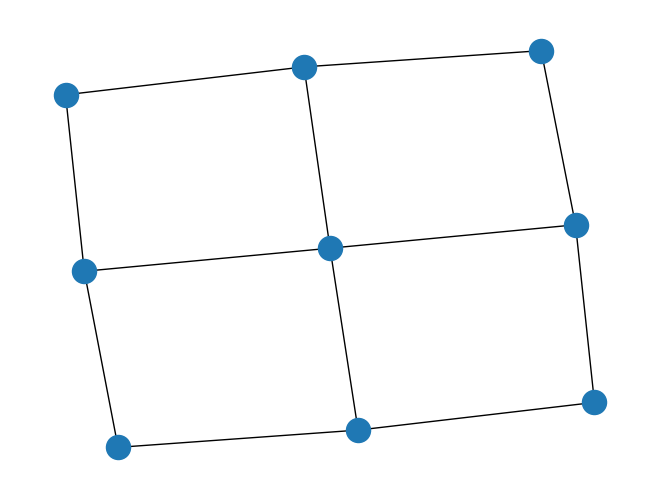

In [6]:
#a triangle lattice which can be embedded on a square can be constructed
#by making a square lattice then adding an edge across the diagonal
#of each square
def nx_triangle_lattice(lattice_size):
    g = nx.generators.lattice.grid_2d_graph(lattice_size,lattice_size)
    for i in range(lattice_size - 1):
        for j in range(lattice_size - 1):
            g.add_edge((i,j),(i+1,j+1))
    return g

test_lattice_size=3
g_square = nx.grid_graph(dim = (test_lattice_size, test_lattice_size))
g_triangle = nx_triangle_lattice(test_lattice_size)
g_cube = nx.generators.grid_graph(dim = (test_lattice_size,test_lattice_size,test_lattice_size))
nx.draw(g_square)

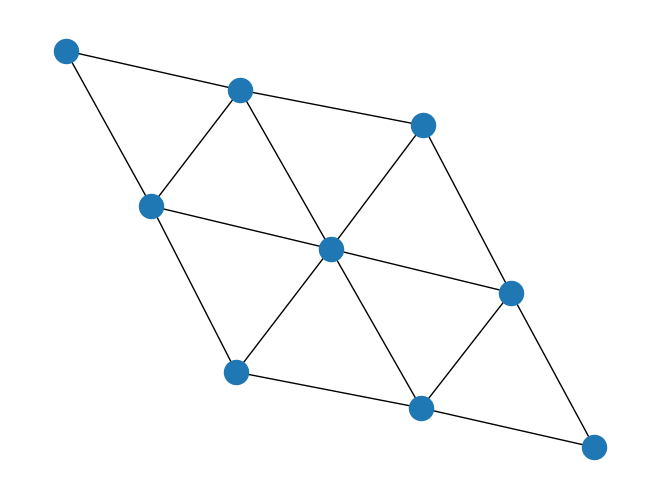

In [7]:
nx.draw(g_triangle)

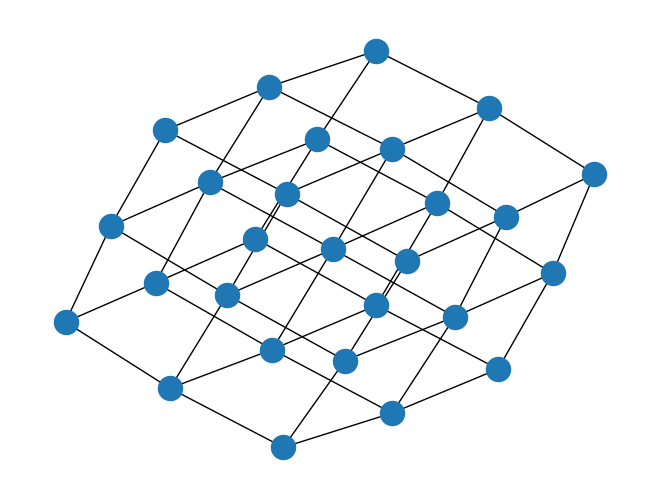

In [8]:
nx.draw(g_cube)

Now that we have an idea of what our Hamiltonians look like, we can begin generating them in a form accepted by pyLIQTR.

In [9]:
###defining helper functions for Hamiltonian string generation

#given a networkx graph g, construct a hamiltonian with random weights
#which can be processed by pyLIQTR
def nx_longitudinal_ising_terms(g,p,magnitude=1):
    H_longitudinal = []
    n = len(g.nodes)
    for (n1,n2) in g.edges:
        weight = magnitude if random.random() < p else -magnitude
        string = n*'I' 
        for i in range(len(g)):
            if i == n1 or i == n2:
                string = string[:i] + 'Z' + string[i+1:]
            else:
                pass
        H_longitudinal.append((string,weight))
    return H_longitudinal

def nx_transverse_ising_terms(g,p,magnitude=0.1):
    H_transverse = []
    n = len(g)
    for i in range(n):
        w = magnitude if random.random() < p else -magnitude
        string = n*'I'
        for k in range(n):
            if i == k:
                string = string[:i] + 'X' + string[i+1:]
            else:
                pass
        H_transverse.append((string, w))
    return H_transverse

def flatten_nx_graph(g):
    new_ids = {}
    count = 0
    for node in g.nodes:
        if node in new_ids:
            pass
        else:
            new_ids[node] = count
            count = count + 1
    new_g = nx.relabel_nodes(g, new_ids)
    return new_g

def generate_square_hamiltonian(lattice_size, longitudinal_weight_prob=0.5, transverse_weight_prob=1):
    g = nx.grid_graph(dim=(lattice_size,lattice_size))
    g = flatten_nx_graph(g)
    H_transverse = nx_transverse_ising_terms(g, transverse_weight_prob)
    H_longitudinal = nx_longitudinal_ising_terms(g, longitudinal_weight_prob)
    return H_transverse, H_longitudinal

def generate_triangular_hamiltonian(lattice_size, longitudinal_weight_prob=1, transverse_weight_prob=1):
    g = nx_triangle_lattice(lattice_size)
    g = flatten_nx_graph(g)
    H_transverse = nx_transverse_ising_terms(g, transverse_weight_prob)
    H_longitudinal = nx_longitudinal_ising_terms(g, longitudinal_weight_prob)
    return H_transverse, H_longitudinal

def generate_cubic_hamiltonian(lattice_size, longitudinal_weight_prob=0.5, transverse_weight_prob=1):
    g = nx.grid_graph(dim=(lattice_size,lattice_size,lattice_size))
    g = flatten_nx_graph(g)
    H_transverse = nx_transverse_ising_terms(g, transverse_weight_prob)
    H_longitudinal = nx_longitudinal_ising_terms(g, longitudinal_weight_prob)
    return H_transverse, H_longitudinal

def estimate_qsp(pyliqtr_hamiltonian, timesteps, energy_precision, outdir, hamiltonian_name="hamiltonian", write_circuits=False):
    timestep_of_interest=1 #for magnus like argument
    angles, tolerances = qspFuncs.compute_hamiltonian_angles(pyliqtr_hamiltonian, simtime=timestep_of_interest, req_prec=energy_precision)
    qsp_generator = pQSP.QSP(phis=angles, hamiltonian=pyliqtr_hamiltonian, target_size=pyliqtr_hamiltonian.problem_size)
    qsp_circuit = qsp_generator.circuit()
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    subcircuit_counts = dict()
    t_counts = dict()
    t_depths = dict()
    t_depth_wires = dict()
    clifford_counts = dict()
    gate_counts = dict()
    subcircuit_depths = dict()
    
    outfile_qasm_high_level = outdir + hamiltonian_name + "_high_level.qasm"
    outfile_data = outdir + hamiltonian_name + "_high_level.dat"
    
    for moment in qsp_circuit:
        for operation in moment:
            gate_type = type(operation.gate)
            if gate_type in subcircuit_counts:
                subcircuit_counts[gate_type] += 1
            
            else:
                outfile_qasm_decomposed = outdir+str(gate_type)[8:-2]+".decomposed.qasm"
                outfile_qasm_cpt = outdir+str(gate_type)[8:-2]+".cpt.qasm"
                
                decomposed_circuit = qsp_decompose_once(qsp_decompose_once(cirq.Circuit(operation)))
                cpt_circuit = clifford_plus_t_direct_transform(decomposed_circuit)
                
                if write_circuits:
                    with open(outfile_qasm_decomposed, 'w') as f:
                        print_to_openqasm(f, decomposed_circuit, qubits=decomposed_circuit.all_qubits())
                    
                    with open(outfile_qasm_cpt, 'w') as f:
                        print_to_openqasm(f, cpt_circuit, qubits=cpt_circuit.all_qubits())
                
                subcircuit_counts[gate_type] = 1
                subcircuit_depths[gate_type] = len(cpt_circuit)
                t_counts[gate_type] = count_T_gates(cpt_circuit)
                gate_counts[gate_type] = count_gates(cpt_circuit)
                t_depths[gate_type] = get_T_depth(cpt_circuit)
                t_depth_wires[gate_type] = get_T_depth_wire(cpt_circuit)
                clifford_counts[gate_type] = gate_counts[gate_type] - t_counts[gate_type]
                
    total_gate_count = 0
    total_gate_depth = 0
    total_T_depth = 0
    total_T_depth_wire = 0
    total_T_count = 0
    total_clifford_count = 0
    for gate in subcircuit_counts:
        total_gate_count += subcircuit_counts[gate] * gate_counts[gate] * timesteps / timestep_of_interest
        total_gate_depth += subcircuit_counts[gate] * subcircuit_depths[gate] * timesteps / timestep_of_interest
        total_T_depth += subcircuit_counts[gate] * t_depths[gate] * timesteps / timestep_of_interest
        total_T_depth_wire += subcircuit_counts[gate] * t_depth_wires[gate] * timesteps / timestep_of_interest
        total_T_count += subcircuit_counts[gate] * t_counts[gate] * timesteps / timestep_of_interest
        total_clifford_count += subcircuit_counts[gate] * clifford_counts[gate] * timesteps / timestep_of_interest
    with open(outfile_data, 'w') as f:
        total_gate_count 
        f.write(str("Logical Qubit Count:"+str(len(qsp_circuit.all_qubits()))+"\n"))
        f.write(str("Total Gate Count:"+str(total_gate_count)+"\n"))
        f.write(str("Total Gate Depth:"+str(total_gate_depth)+"\n"))
        f.write(str("Total T Count:"+str(total_T_count)+"\n"))
        f.write(str("Total T Depth:"+str(total_T_depth)+"\n"))
        f.write(str("Maximum T Count on Single Wire:"+str(total_T_depth_wire)+"\n"))
        f.write(str("Total Clifford Count:"+str(total_clifford_count)+"\n"))
        f.write("Subcircuit Info:\n")
        for gate in subcircuit_counts:
            f.write(str(str(gate)+"\n"))
            f.write(str("Subcircuit Occurrences:"+str(subcircuit_counts[gate]*timesteps)+"\n"))
            f.write(str("Gate Count:"+str(gate_counts[gate])+"\n"))
            f.write(str("Gate Depth:"+str(subcircuit_depths[gate])+"\n"))
            f.write(str("T Count:"+str(t_counts[gate])+"\n"))
            f.write(str("T Depth:"+str(t_depths[gate])+"\n"))
            f.write(str("Maximum T Count on a Single Wire:"+str(t_depth_wires[gate])+"\n"))
            f.write(str("Clifford Count:"+str(clifford_counts[gate])+"\n"))
    return qsp_circuit

In [10]:
##initializing seed for consistent results for the cubic lattice and generating Hamiltonians
random.seed(0)
np.random.seed(0)
square_lattice_size=10
triangle_lattice_size=32
cubic_lattice_size=12
test_lattice_size=3

square_hamiltonian = generate_square_hamiltonian(square_lattice_size)
triangular_hamiltonian = generate_triangular_hamiltonian(triangle_lattice_size)
cubic_hamiltonian = generate_cubic_hamiltonian(cubic_lattice_size)
#square_hamiltonian = generate_square_hamiltonian(test_lattice_size)
#triangular_hamiltonian = generate_triangular_hamiltonian(test_lattice_size)
#cubic_hamiltonian = generate_cubic_hamiltonian(test_lattice_size)

Now that we have generated our Hamiltonians, we can start generating the circuits for a preferred dynamic simulation method (e.g., QSP, Trotter 4th order, ...).  Shown below is QSP.

In [11]:
timesteps=1000
required_precision = 1e-16

In [12]:
#feeding square Hamiltonian to PyLIQTR for circuit generation
H_square = pyH(square_hamiltonian[0] + square_hamiltonian[1])
H_triangle = pyH(triangular_hamiltonian[0] + triangular_hamiltonian[1])
H_cube = pyH(cubic_hamiltonian[0] + cubic_hamiltonian[1])

Now we need to extract resource estimates for each of the subcircuits of the high level circuit.  The information which we are interested in is as follows:
* Total gate count for full circuit
* Total depth for full circuit
* Decomposed QASM circuit for each subcircuit
* Clifford + T circuits for each subcircuit
* Total T gate count for each subcircuit
* Total Clifford count for each subcircuit
* T gate depth for each subcircuit

This information can be extracted by obtaining the information for each subcircuit and multiplying by the number of repetitions of the subcircuits.  In this
notebook, we show the process for both QSP and second order Suzuki-Trotter, though this process could likely be generalized to many quantum algorithms.
It should be noted that the approach shown here provides a slight over-estimation since it assumes that each of the subcircuits operate in serial.  This
assumption is valid for both QSP and second order Suzuki-Trotter since the operations which consume the bulk of the circuit volume do operate in serial
(Select and Reflect Operations and Trotter steps respectively).

In [13]:
print("Estimating Square", flush=True)
qsp_circ_square = estimate_qsp(H_square, timesteps, required_precision, "QSP/square_circuits/", hamiltonian_name="square")
print("Estimating Triangle", flush=True)
qsp_circ_triangle = estimate_qsp(H_triangle, timesteps, required_precision, "QSP/triangle_circuits/", hamiltonian_name="triangle")
print("Estimating Cube", flush=True)
qsp_circ_cube = estimate_qsp(H_cube, timesteps, required_precision, "QSP/cube_circuits/", hamiltonian_name="cube")
print("Finished estimating", flush=True)

Estimating Square
Estimating Triangle
Estimating Cube
Finished estimating


# More complicated Hamiltonian
There are a few ways to make the simulation task more challenging and more application relevant.
The Kitaev honeycomb model is hypothesized to be a good model for the structure of many materials (see for example [here](https://www.sciencedirect.com/science/article/pii/S0370157321004051)).  This model is appealing for quantum simulation purposes because while the behavior in the infinite time regime is [understood](https://www.cambridge.org/core/books/introduction-to-topological-quantum-computation/kitaevs-honeycomb-lattice-model/85E968DD7C54F8062C4EAF5394DAAAF6), the behavior with minor perturbations to the model or the dynamics of the model are not so well [understood](https://courses.physics.illinois.edu/phys598PTD/fa2013/L26.pdf).  The Kitaev honeycomb model consists of directionally defined $XX$, $YY$, and $ZZ$ couplings on a honeycomb lattice.  These assignments are denoted in the plot below by 'X', 'Y', or 'Z' respectively.

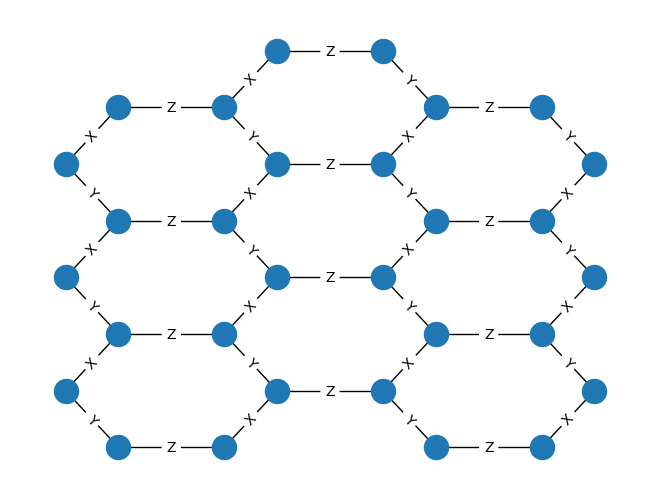

In [13]:
def assign_hexagon_labels(g):
    for n1, n2 in g.edges:
        #start by making sure that the edges are ordered correctly
        r1,c1 = n1
        r2,c2 = n2
        if r2 - r1 < 0 or c2 - c1 < 0:
            swap_r2 = r1
            swap_c2 = c1
            r1 = r2
            c1 = c2
            r2 = swap_r2
            c2 = swap_c2
        
        #now that they are ordered correctly, we can assign labels
        label = ''
        if c1 == c2:
            label = 'Z'
        elif (((r1 % 2) + (c1 % 2)) % 2 == 0):#apparently you can differentiate X and Y labels based off nx's node label parity.  Huh.
            label = 'Y'
        else:
            label = 'X'
        
        g[n1][n2]['label'] = label

g_hexagon = nx.generators.lattice.hexagonal_lattice_graph(3,3)
pos = nx.get_node_attributes(g_hexagon, 'pos')
assign_hexagon_labels(g_hexagon)
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_hexagon.edges(data=True)]);
nx.draw(g_hexagon, pos)
nx.draw_networkx_edge_labels(g_hexagon, pos,edge_labels = edge_labels);

From this graph we can generate the Hamiltonian
\begin{equation*}
H_{\text{Kitaev}} = \sum_{(i,j) \in X \text{ edges}} J_{i,j} \sigma_i^x \sigma_j^x + \sum_{(i,j) \in Y \text{ edges}} J_{i,j} \sigma_i^y \sigma_j^y + \sum_{(i,j) \in Z \text{ edges}} J_{i,j} \sigma_i^z \sigma_j^z
\end{equation*}

In [14]:
def nx_kitaev_terms(g, p):
    H = []
    n = len(g.nodes)
    for (n1,n2,d) in g.edges(data=True):
        label = d['label']
        weight = 1 if random.random() < p else -1
        string = n*'I' 
        for i in range(len(g)):
            if i == n1 or i == n2:
                string = string[:i] + label + string[i+1:]
            else:
                pass
        H.append((string,weight))
    return H

def generate_kitaev_hamiltonian(lattice_size, weight_prob=1):
    g = nx.generators.lattice.hexagonal_lattice_graph(lattice_size,lattice_size)
    assign_hexagon_labels(g)
    g = flatten_nx_graph(g)
    H = nx_kitaev_terms(g, weight_prob)
    return H

In [15]:
lattice_size_kitaev = 32
kitaev_hamiltonian = generate_kitaev_hamiltonian(lattice_size_kitaev)

timesteps=1000
required_precision   = 1e-16
H_kitaev = pyH(kitaev_hamiltonian)
print("Estimating Kitaev", flush=True)
qsp_circ_kitaev = estimate_qsp(H_kitaev, timesteps, required_precision, "QSP/kitaev_circuits/", hamiltonian_name="kitaev")
print("Finished Estimating", flush=True)

Estimating Kitaev
Finished Estimating


In [16]:
def assign_directional_triangular_labels(g,lattice_size): 
    for i in range(lattice_size - 1):
        for j in range(lattice_size - 1):
            g[(i,j)][(i+1,j)]['label'] = 'Z'
            g[(i,j)][(i,j+1)]['label'] = 'X'
            g[(i,j)][i+1,j+1]['label'] = 'Y'
        g[(i,lattice_size-1)][(i+1,lattice_size-1)]['label'] = 'Z'
    for j in range(lattice_size - 1):
        g[(lattice_size-1,j)][(lattice_size-1,j+1)]['label'] = 'X'

def generate_directional_triangular_hamiltonian(lattice_size, weight_prob = 1):
    g = nx_triangle_lattice(lattice_size)
    assign_directional_triangular_labels(g,lattice_size)
    g = flatten_nx_graph(g)
    H = nx_kitaev_terms(g, weight_prob)
    return H

g_triangle = nx_triangle_lattice(3)
assign_directional_triangular_labels(g_triangle,3)

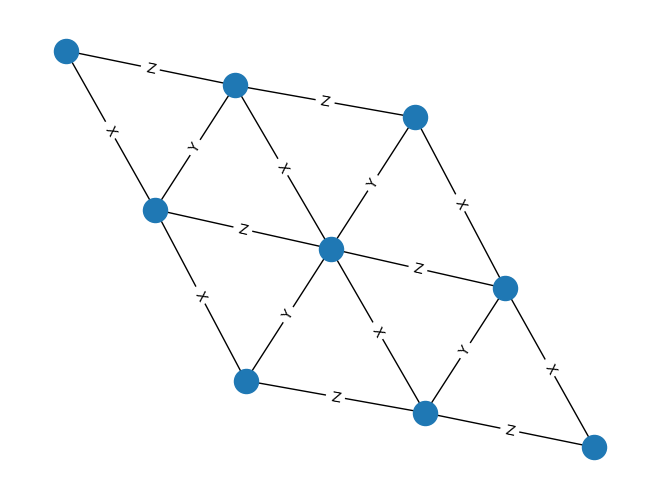

In [17]:
g_triangle = nx_triangle_lattice(3)
assign_directional_triangular_labels(g_triangle,3)
pos = nx.spring_layout(g_triangle)
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_triangle.edges(data=True)]);
nx.draw(g_triangle,pos)
nx.draw_networkx_edge_labels(g_triangle,pos,edge_labels = edge_labels);

In [18]:
lattice_size_directional_triangle = 32
directional_triangle_hamiltonian = generate_directional_triangular_hamiltonian(lattice_size_directional_triangle)

timesteps=1000
required_precision   = 1e-16
timestep_of_interest = 1 # sim_time
H_directional_triangle = pyH(directional_triangle_hamiltonian)

print("Estimating Directional Triangle", flush=True)
qsp_circ_directional_triangle = estimate_qsp(H_directional_triangle, timesteps, required_precision, "QSP/directional_triangle_circuits/", hamiltonian_name="directional_triangle")
print("Finished Estimating", flush=True)

Estimating Directional Triangle
Finished Estimating


# Trotter imeplementations
Now we can do all of this again for second order Suzuki Trotter rather than QSP.  Below we will see how to construct a single trotter step of second order Suzuki-Trotter for these hamiltonians along with a loose upper bound for the number of trotter steps required.  According to the [documentation](https://quantumai.google/reference/python/openfermion/circuits/error_bound) from openfermion the trotter step estimate for the second order Suzuki-Trotter expansion.

In [19]:
def find_hamiltonian_ordering(of_hamiltonian):
    """
    Function to generate a near optimal term ordering for trotterization of transverse field Ising Models.
    This would need to be modified if there were multi-qubit interactions that were not just ZZ
    """
    #ordering hamiltonian terms by performing edge coloring to make optimal trotter ordering
    #assuming that any 2 body interactions are ZZ
    sorted_terms = sorted(list(of_hamiltonian.terms.keys()))
    sorted_terms.sort(key=lambda x: len(x) * 100 + ord(x[0][1])) #Z and X get translated to 90 and 88 respectively, multiplying by 100 ensures interacting term weight is considered
    one_body_terms_ordered = list(filter(lambda x: len(x) == 1, sorted_terms))
    two_body_terms = list(filter(lambda x: len(x) == 2, sorted_terms))
    
    #assigning edge colorings to order two body terms
    g = nx.Graph()
    for term in two_body_terms:
        edge = (term[0][0], term[1][0])
        g.add_edge(*edge)
    edge_coloring = nx.greedy_color(nx.line_graph(g))
    nx.set_edge_attributes(g, edge_coloring, "color")
    colors = list()
    for (i,term) in enumerate(two_body_terms):
        n1,n2 = (term[0][0], term[1][0])
        color = g.edges[n1,n2]['color']
        term = (*term, color)
        two_body_terms[i] = term
    
    two_body_terms.sort(key=lambda x: x[2])
    two_body_terms_ordered = list()
    for (i,term) in enumerate(two_body_terms):
        new_item = (term[0],term[1])
        two_body_terms_ordered.append((term[0], term[1]))
    return one_body_terms_ordered + two_body_terms_ordered

def estimate_trotter(openfermion_hamiltonian,timesteps, energy_precision, outdir, hamiltonian_name="hamiltonian", write_circuits=False):
    nsteps = openfermion.circuits.trotter_steps_required(trotter_error_bound = openfermion.circuits.error_bound(list(openfermion_hamiltonian.get_operators()),tight=False),
                                                time = timesteps, 
                                                energy_precision = energy_precision)
    term_ordering = find_hamiltonian_ordering(openfermion_hamiltonian)
    trotter_circuit_of = openfermion.circuits.trotter_exp_to_qgates.trotterize_exp_qubop_to_qasm(openfermion_hamiltonian, trotter_order=2, evolution_time=timesteps/nsteps, term_ordering=term_ordering)
    qasm_str_trotter = open_fermion_to_qasm(openfermion.count_qubits(openfermion_hamiltonian), trotter_circuit_of)
    trotter_circuit_qasm = qasm_import.circuit_from_qasm(qasm_str_trotter)
    cpt_trotter = clifford_plus_t_direct_transform(trotter_circuit_qasm)
    
    #writing the the higher level trotter circuit to a file as well as the clifford + T circuit
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    if write_circuits:
        outfile_qasm_decomposed = outdir + "trotter_circuit_" + hamiltonian_name + ".qasm" 
        outfile_qasm_cpt = outdir + "trotter_cpt_" + hamiltonian_name + ".qasm"
        with open(outfile_qasm_decomposed, 'w') as f:
            print_to_openqasm(f, trotter_circuit, qubits=trotter_circuit.all_qubits())
        with open(outfile_qasm_cpt, 'w') as f:
            print_to_openqasm(f, cpt_trotter, qubits=cpt_trotter.all_qubits())
        
    outfile_data = outdir + "trotter_" + hamiltonian_name + ".dat"
    gate_count = count_gates(cpt_trotter)
    t_count = count_T_gates(cpt_trotter)
    t_depth = get_T_depth(cpt_trotter)
    t_depth_wire = get_T_depth_wire(cpt_trotter)
    with open(outfile_data, 'w') as f:
        f.write("Logical Qubit Count:"+str(len(cpt_trotter.all_qubits()))+"\n")
        f.write("Number of Trotter Steps Required (Loose Upper Bound):"+ str(nsteps) +"\n")
        f.write("Total T Depth:"+str(t_depth * nsteps)+"\n")
        f.write("Maximum T Count on a Single Wire:"+str(t_depth_wire * nsteps)+"\n")
        f.write("Single Step Gate Count:"+str(gate_count)+"\n")
        f.write("Single Step Gate Depth:"+str(len(cpt_trotter))+"\n")
        f.write("Single Step T Count:"+str(t_count)+"\n")
        f.write("Single Step T Depth:"+str(t_depth)+"\n")
        f.write("Single Step Maximum T Count on a Single Wire:"+str(t_depth_wire)+"\n")
        f.write("Single Step Clifford Count:"+str(gate_count - t_count)+"\n")
    
    return cpt_trotter

In [20]:
##Translating the hamiltonians from above into a form usable by openfermion
openfermion_hamiltonian_square = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_square)
openfermion_hamiltonian_triangle = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_triangle)
openfermion_hamiltonian_cube = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_cube)
openfermion_hamiltonian_kitaev = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_kitaev)
openfermion_hamiltonian_directional_triangle = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_directional_triangle)

In [21]:
#defining precision required for the trotterized circuit
energy_precision = 1e-6
timesteps=1000

## Estimates
Trotterizing the Hamiltonians and writing estimates to files

In [22]:
print("Estimating Square", flush=True)
cpt_trotter_square = estimate_trotter(openfermion_hamiltonian_square, timesteps, energy_precision, "Trotter/square_circuits/", hamiltonian_name="square")
print("Estimating Triangle", flush=True)
cpt_trotter_triangle = estimate_trotter(openfermion_hamiltonian_triangle, timesteps, energy_precision, "Trotter/triangle_circuits/", hamiltonian_name="triangle")
print("Estimating Cube", flush=True)
cpt_trotter_cube = estimate_trotter(openfermion_hamiltonian_cube, timesteps, energy_precision, "Trotter/cube_circuits/", hamiltonian_name="cube")
print("Estimating Kitaev", flush=True)
cpt_trotter_kitaev = estimate_trotter(openfermion_hamiltonian_kitaev, timesteps, energy_precision, "Trotter/kitaev_circuits/", hamiltonian_name="kitaev")
print("Estimating Directional Triangle", flush=True)
cpt_trotter_directional_triangle = estimate_trotter(openfermion_hamiltonian_directional_triangle, timesteps, energy_precision, "Trotter/directional_triangle_circuits/", hamiltonian_name="directional_triangle")
print("Finished with estimates", flush=True)

Estimating Square
Estimating Triangle
Estimating Cube
Estimating Kitaev
Estimating Directional Triangle
Finished with estimates


In [23]:
figdir = "Trotter/Figures/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

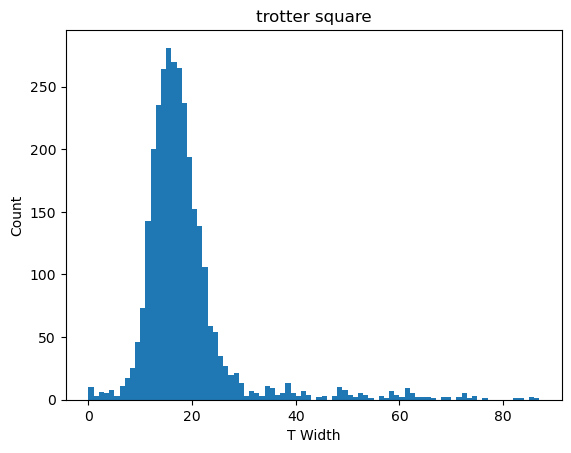

In [24]:
plot_T_step_histogram(cpt_trotter_square)
plt.title("trotter square")
plt.xlabel("T Width")
plt.ylabel("Count")
plt.savefig(figdir + "trotter_cpt_t_width_histogram_square.pdf")

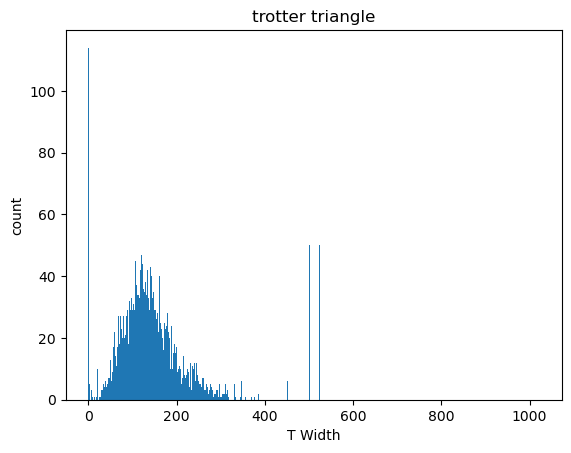

In [25]:
plot_T_step_histogram(cpt_trotter_triangle)
plt.title("trotter triangle")
plt.xlabel("T Width")
plt.ylabel("count")
plt.savefig(figdir + "trotter_cpt_t_width_histogram_triangle.pdf")

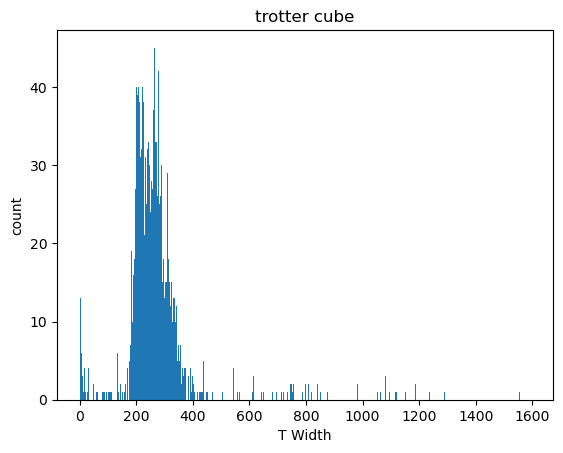

In [26]:
plot_T_step_histogram(cpt_trotter_cube)
plt.title("trotter cube")
plt.xlabel("T Width")
plt.ylabel("count")
plt.savefig(figdir + "trotter_cpt_t_width_histogram_cube.pdf")

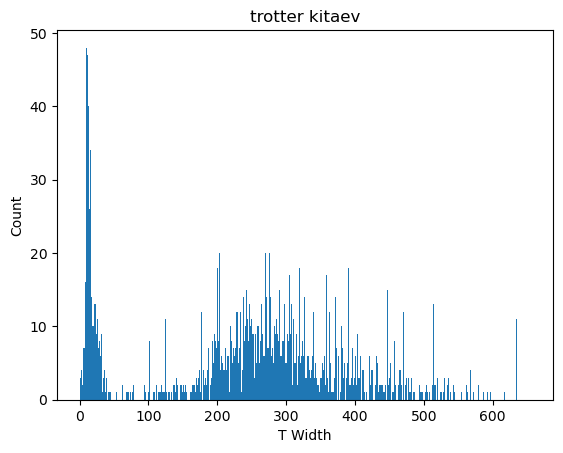

In [27]:
plot_T_step_histogram(cpt_trotter_kitaev)
plt.title("trotter kitaev")
plt.xlabel("T Width")
plt.ylabel("Count")
plt.savefig(figdir + "trotter_cpt_t_width_histogram_kitaev.pdf")

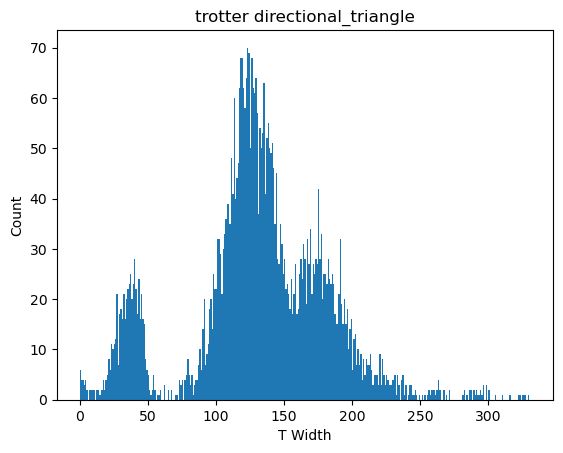

In [28]:
plot_T_step_histogram(cpt_trotter_directional_triangle)
plt.title("trotter directional_triangle")
plt.xlabel("T Width")
plt.ylabel("Count")
plt.savefig(figdir + "trotter_cpt_t_width_histogram_directional_triangle.pdf")

In [29]:
t_final = time.perf_counter()
print("Total Notebook Runtime: " + str(t_final))

Total Notebook Runtime: 1674.966680286
